In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from gensim.models import Word2Vec
import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
train=pd.read_csv("Training_set.csv")

In [3]:
test=pd.read_csv("Test_set.csv")

In [4]:
def get_job_characteristics(df): 
    job_type=[]
    job_title=[]
    employer_title=[]
    employer_sector_title=[]
    job_sector_title=[]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        types=data["job_type"]
        title=data["job_title"]
        em_title=data["employer_title"]
        em_sec_title=data["employer_sector_title"]
        job_sec_title=data["job_sector_title"]
        job_type.append(types)
        job_title.append(title)
        employer_title.append(em_title)
        employer_sector_title.append(em_sec_title)
        job_sector_title.append(job_sec_title)
    d={}
    #d["job_title"]=job_title
    #d["employer_title"]=employer_title
    d["employer_sector_title"]=employer_sector_title
    d["job_sector_title"]=job_sector_title
    a=pd.DataFrame(d)
    data=pd.get_dummies(a)
    b=pd.get_dummies(job_type)
    result = pd.concat([data, b], axis=1, sort=False)
    return result

In [4]:
train.columns

Index(['Unnamed: 0', 'user_id', 'job_id', 'employer_id', 'job_opening_date',
       'job_closing_date', 'job_description', 'job_type', 'job_title',
       'employer_title', 'employer_description', 'employer_sector_id',
       'employer_sector_title', 'jobsector_id', 'job_sector_title', 'gender',
       'ethnicity', 'school_type', 'course_includes_industrial_placement',
       'graduation_year', 'right_to_work_uk', 'degree_subject_id',
       'university_id', 'university_name', 'university_type',
       'degree_subject_name', 'user_preference'],
      dtype='object')

In [39]:
def get_data_for_user(user):
    jobtitles=list(user["job_title"].values)
    emtitles=list(user["employer_title"].values)
    jobsectitles=list(user["job_sector_title"].values)
    emsectitles=list(user["employer_sector_title"].values)
    a=""
    for k in range(len(jobtitles)):
        a+=jobtitles[k]+" "
        a+=emtitles[k]+" "
        a+=jobsectitles[k]+" "
        a+=emsectitles[k]+" "
    return a

In [40]:
def get_user_characteristics(df):
    corpus=[]
    gender=[]
    ethnicity=[]
    school_type=[]
    right_to_work_uk=[]
    university_name=[]
    university_type=[]
    course_includes_industrial_placement=[]
    degree_subject_name=[]
    user_preference=[]
    job_types=list(set(df["job_type"].values))
    em_sectors=list(set(df["employer_sector_title"].values))
    job_sectors=list(set(df["job_sector_title"].values))
    count_job_types=[[] for i in range(len(job_types))]
    count_job_sectors=[[] for i in range(len(job_sectors))]
    count_em_sectors=[[] for i in range(len(em_sectors))]
    nb_em_sector=[]
    nb_job_sector=[]
    job_type=[]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        user=data["user_id"]
        user_data=df[df["user_id"]==user]
        user_job_type=dict(Counter(list(user_data["job_type"].values)))
        user_job_sectors=dict(Counter(list(user_data["job_sector_title"].values)))
        user_em_sectors=dict(Counter(list(user_data["employer_sector_title"].values)))
        user_em_sector=len(list(set(list(user_data["employer_sector_title"].values))))
        user_job_sector=len(list(set(list(user_data["job_sector_title"].values))))
        for i in range(len(count_job_types)):
            try:
                count_job_types[i].append(user_job_type[i])
            except:
                count_job_types[i].append(0)
        for i in range(len(count_job_sectors)):
            try:
                count_job_sectors[i].append(user_job_sectors[i])
            except:
                count_job_sectors[i].append(0)
        for i in range(len(count_em_sectors)):
            try:
                count_em_sectors[i].append(user_em_sectors[i])
            except:
                count_em_sectors[i].append(0)
        sex=data["gender"]
        jobtype=data["job_type"]
        eth=data["ethnicity"]
        school=data["school_type"]
        placement=data["course_includes_industrial_placement"]
        right=data["right_to_work_uk"]
        uni=data["university_name"]
        uni_type=data["university_type"]
        subname=data["degree_subject_name"]
        pref=data["user_preference"]
        title=data["job_title"]
        em_title=data["employer_title"]
        em_sec_title=data["employer_sector_title"]
        job_sec_title=data["job_sector_title"]
        if sex=="F":
            sex="Female"
        elif sex=="M":
            sex="Male"
        if placement==True:
            placement=1
        elif placement==False:
            placement=-1
        else:
            placement=0
        if right==True:
            right=1
        elif right==False:
            right=-1
        else:
            right=0
        if type(pref) is float:
            pref=""
        if type(subname) is float:
            subname=""
        nb_em_sector.append(user_em_sector)
        nb_job_sector.append(user_job_sector)
        gender.append(sex)
        ethnicity.append(eth)
        school_type.append(school)
        course_includes_industrial_placement.append(placement)
        right_to_work_uk.append(right)
        university_type.append(uni_type)
        #degree_subject_name.append(subname)
        #user_preference.append(pref)
        job_type.append(jobtype)
        corpus.append(pref+subname+" "+get_data_for_user(user_data))
    d={}
    for i in range(len(count_job_sectors)):
        d['count_job_sectors_'+str(i)]=count_job_sectors[i]
    for i in range(len(count_em_sectors)):
        d['count_em_sectors_'+str(i)]=count_em_sectors[i]
    for i in range(len(count_job_types)):
        d['count_job_types_'+str(i)]=count_job_types[i]
    d["gender"]=gender
    d["job_type"]=job_type
    d["nb_em_sector"]=nb_em_sector
    d["nb_job_sector"]=nb_job_sector
    d["right_to_work_uk"]=right_to_work_uk
    d["ethnicity"]=ethnicity
    #d["degree_subject_name"]=degree_subject_name
    d["school_type"]=school_type
    #d["user_preference"]=user_preference
    d["course_includes_industrial_placement"]=course_includes_industrial_placement
    a=pd.DataFrame(d)
    data=pd.get_dummies(a)
    b=pd.get_dummies(university_type)
    result = pd.concat([data, b], axis=1, sort=False)
    vectorizer = CountVectorizer(max_df=1.0, min_df=3)
    X = vectorizer.fit_transform(corpus)
    col=vectorizer.get_feature_names()
    donnees=X.toarray()
    print(X.shape)
    donnee=pd.DataFrame(donnees, columns=col)
    final=pd.concat([result, donnee], axis=1)
    return final

In [41]:
user_characteristics=get_user_characteristics(train)

(125136, 1876)


In [42]:
user_characteristics.shape

(125136, 1960)

In [43]:
users=list(train["user_id"].values)
users=[str(i) for i in users]

In [44]:
pca = PCA(n_components=2)
test_user = pca.fit_transform(user_characteristics)

In [45]:
print(pca.explained_variance_ratio_)

[0.99564384 0.00152969]


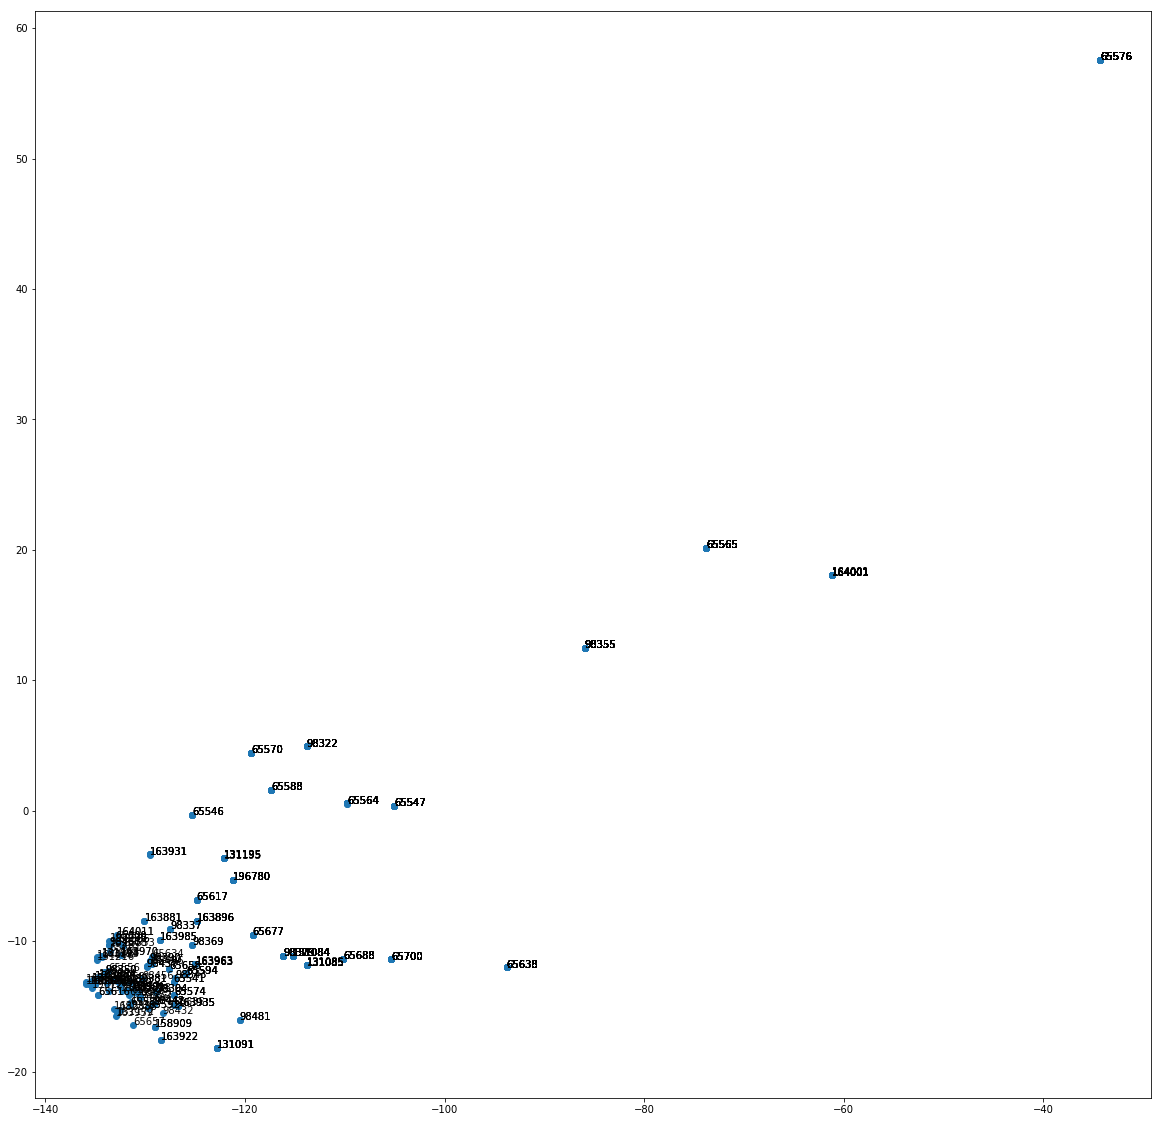

In [51]:
k=500
plt.figure(figsize=(20,20))
plt.scatter(test_user[:k, 0], test_user[:k, 1])
for i, word in enumerate(users[:k]):
    plt.annotate(word, xy=(test_user[i, 0], test_user[i, 1]))
plt.show()

# Right

In [36]:
train[train["user_id"]==164402][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'job_type', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,job_type,gender,ethnicity,university_name,degree_subject_name,user_preference
1437,Business Graduate Programme,London Stock Exchange Group,Financial Services,Financial Services,1.0,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN
1438,Graduate Data Analyst - Planning and Pricing,Cognizant,Technology: Consulting & Project Management,Technology: Consulting & Project Management,1.0,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN
1439,Global Research Global Graduate Programme,HSBC,Financial Services,Financial Services,1.0,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN
1440,Alpha Financial Markets Consulting Analyst,Alpha FMC,Financial Services,Financial Services,1.0,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN
1441,Cognizant Graduate Digital Careers,Cognizant,Technology: Consulting & Project Management,Technology: Consulting & Project Management,1.0,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN
1442,General Graduate Development Programme,Wellcome Trust,Charity & Social Enterprise,Charity & Social Enterprise,1.0,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN
1443,Retail Banking and Wealth Management - Graduat...,HSBC,Financial Services,Financial Services,1.0,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN


In [49]:
train[train["user_id"]==65576][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'job_type', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,job_type,gender,ethnicity,university_name,degree_subject_name,user_preference
203,Internship,Oliver Wyman,Consulting,Consulting,3.0,Male,NaN,University of Southampton,Economics,Investment Banking Investment & Asset Manageme...
204,Summer Internships,MUFG,Financial Services,Financial Services,3.0,Male,NaN,University of Southampton,Economics,Investment Banking Investment & Asset Manageme...
205,Actuarial Graduate Opportunities 2018,PwC,Technology: Consulting & Project Management,Financial Services,1.0,Male,NaN,University of Southampton,Economics,Investment Banking Investment & Asset Manageme...
206,Summer Analyst Program 2018 (EMEA Business Focus),BNY Mellon,Financial Services,Financial Services,1.0,Male,NaN,University of Southampton,Economics,Investment Banking Investment & Asset Manageme...
207,Entry-Level Consultant,Oliver Wyman,Consulting,Consulting,1.0,Male,NaN,University of Southampton,Economics,Investment Banking Investment & Asset Manageme...
208,Finance Graduate Program,Amazon,"Consumer, FMCG & Retail",Financial Services,1.0,Male,NaN,University of Southampton,Economics,Investment Banking Investment & Asset Manageme...
209,Full-time Opportunities,BMO Capital Markets,Financial Services,Financial Services,1.0,Male,NaN,University of Southampton,Economics,Investment Banking Investment & Asset Manageme...


# Left

In [50]:
train[train["user_id"]==66117][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'job_type', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,job_type,gender,ethnicity,university_name,degree_subject_name,user_preference
1510,Technology Graduate Schemes 2018,PwC,Technology: Consulting & Project Management,Technology: Consulting & Project Management,1.0,Male,Black/African/Carribean/Black British,University of Warwick,Engineering,"Consumer, FMCG & Retail Energy & Infrastructur..."
1511,Summer Internship: Data Science,Expedia,"Consumer, FMCG & Retail",Technology: Consulting & Project Management,3.0,Male,Black/African/Carribean/Black British,University of Warwick,Engineering,"Consumer, FMCG & Retail Energy & Infrastructur..."
1512,Summer Internship,EY,Financial Services,Technology: Consulting & Project Management,3.0,Male,Black/African/Carribean/Black British,University of Warwick,Engineering,"Consumer, FMCG & Retail Energy & Infrastructur..."
1513,"Production Engineer, Intern (Dublin)",Facebook,Technology: Consulting & Project Management,Technology: Consulting & Project Management,3.0,Male,Black/African/Carribean/Black British,University of Warwick,Engineering,"Consumer, FMCG & Retail Energy & Infrastructur..."
1514,Technology Innovation Industrial Placement,Citrix,Technology: IT & Software Development,Technology: IT & Software Development,4.0,Male,Black/African/Carribean/Black British,University of Warwick,Engineering,"Consumer, FMCG & Retail Energy & Infrastructur..."
1515,Software Engineering - 12 Month Placement/Inte...,GE,Technology: Consulting & Project Management,Technology: IT & Software Development,3.0,Male,Black/African/Carribean/Black British,University of Warwick,Engineering,"Consumer, FMCG & Retail Energy & Infrastructur..."
1516,Undergraduate Summer Placement 2018 ? Software...,Balfour Beatty,Technology: Consulting & Project Management,Technology: IT & Software Development,3.0,Male,Black/African/Carribean/Black British,University of Warwick,Engineering,"Consumer, FMCG & Retail Energy & Infrastructur..."


In [52]:
train[train["user_id"]==163922][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'job_type', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,job_type,gender,ethnicity,university_name,degree_subject_name,user_preference
314,Commercial Leadership (B2B),E.ON,Energy & Infrastructure,Technology: Consulting & Project Management,1.0,Male,Asian/Asian British,University of Reading,Quantity Surveying,NaN
315,Business Management Graduate,Fujitsu,Technology: Consulting & Project Management,Technology: Consulting & Project Management,1.0,Male,Asian/Asian British,University of Reading,Quantity Surveying,NaN
316,"Risk, Conduct and Restructuring",RBS,Technology: Consulting & Project Management,Investment & Asset Management,1.0,Male,Asian/Asian British,University of Reading,Quantity Surveying,NaN


In [53]:
train[train["user_id"]==131091][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'job_type', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,job_type,gender,ethnicity,university_name,degree_subject_name,user_preference
76,Graduate Commercial Programme,Tessian,Technology: Consulting & Project Management,Technology: Consulting & Project Management,1.0,Male,Black/African/Carribean/Black British,University of Leicester,Engineering - Mechanical,NaN
77,Graduate Technology Community,Capgemini,Technology: Consulting & Project Management,Technology: Consulting & Project Management,1.0,Male,Black/African/Carribean/Black British,University of Leicester,Engineering - Mechanical,NaN
78,Business Analyst,Focus Group,Financial Services,Sales & Commercial,1.0,Male,Black/African/Carribean/Black British,University of Leicester,Engineering - Mechanical,NaN
79,Digital Graduate Programme 2018,Sopra Steria,Technology: Consulting & Project Management,Technology: Consulting & Project Management,1.0,Male,Black/African/Carribean/Black British,University of Leicester,Engineering - Mechanical,NaN
80,Operations Manager,Cudoni,"Consumer, FMCG & Retail","Consumer, FMCG & Retail",1.0,Male,Black/African/Carribean/Black British,University of Leicester,Engineering - Mechanical,NaN
81,Energy Specialist,Bulb,Entrepreneurship & Start Ups,Energy & Infrastructure,1.0,Male,Black/African/Carribean/Black British,University of Leicester,Engineering - Mechanical,NaN


In [8]:
job_characteristics=get_job_characteristics(train)

In [9]:
job_characteristics.shape

(125136, 57)

In [10]:
def get_user_info(df):
    user_info=[]
    x=train[["user_id","job_title","employer_title"]]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        user_id=data["user_id"]
        y=x[x["user_id"]==user_id]
        job_titles=y["job_title"].values
        em_titles=y["employer_title"].values
        university_name=data["university_name"]
        degree_subject_name=data["degree_subject_name"]
        user_preference=data["user_preference"]
        ethnicity=data["ethnicity"]
        school_type=data["school_type"]
        if type(user_preference) is float:
            user_preference=""
        if type(university_name) is float:
            university_name=""
        if type(degree_subject_name) is float:
            degree_subject_name=""
        if type(ethnicity) is float:
            ethnicity=""
        if type(school_type) is float:
            school_type=""
        a=""
        a+=university_name+" "
        a+=degree_subject_name+" "
        a+=user_preference+" "
        a+=ethnicity+" "
        a+=school_type+" "
        for k in range(len(job_titles)):
            a+=job_titles[k]+" "
            a+=em_titles[k]+" "
        user_info.append(a)
    return user_info

In [11]:
train_user_info=get_user_info(train)

In [12]:
train_user_info[100]

'City University London Economics Accounting, Tax & Audit Prefer not to say Grammar 2018 September Intake - Graduate - EMEIA Tax Centre - London Graduate Consultant - Climate Change & Cities Graduate Accountancy Scheme - London Graduate Programme Consulting Graduate Programme (In association with Teach First) Graduate Investment Programme Finance Scheme Tax Graduate-programme Graduate Programme Graduate Operational Improvement Consultant Tax Graduate Programme Investment Banking Full-Time Analyst Programme ? London Graduate Programme Junior Broker Welsh Financial Services Graduate Programme Audit Graduate Trainee  - 2018 Audit Assistant Graduate Audit Graduate Women in Business (final years) - 2018 Actuarial Consulting - Pensions Alpha Financial Markets Consulting Analyst Tax Graduate Opportunities Strategy Graduate Programme New Analyst Programme International Graduate Programme Finance Programme Actuarial Graduate Opportunities 2018 Retail Banking and Wealth Management - Graduate Pro

In [13]:
def clean_user(x):
    res=[] 
    for content in x:
        content=content.replace(",","").replace("-"," ").replace("  "," ")
        content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
        content=content.split(" ")
        y=[]
        for i in content:
            if len(i)>1:
                y.append(i.lower())
        res.append(y)
    return res

In [14]:
clean_train_user_info=clean_user(train_user_info)

In [15]:
def get_job_info(df):
    job_info=[]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        title=data["job_title"]
        job_sector_title=data["job_sector_title"]
        description=data["job_description"]
        em_title=data["employer_title"]
        em_sector_title=data["employer_sector_title"]
        em_description=data["employer_description"]
        a=""
        a+=title+" "
        a+=job_sector_title+" "
        a+=description+" "
        a+=em_title+" "
        a+=em_sector_title+" "
        a+=em_description
        job_info.append(a)
    return job_info

In [16]:
train_job_info=get_job_info(train)

In [17]:
def clean(x):
    res=[] 
    for content in x:
        content=content.replace("&bull;","\r\n ").replace("\r\r\n\t"," ").replace("\r\r\n"," ")
        content=content.replace("\r\r\n\r\r\n"," ").replace("..."," ").replace("&#39;s","").replace(":","")
        content=content.replace("&eacute;","e").replace("&lsquo;","").replace("&#39;","")
        content=content.replace("&nbsp;"," ").replace("&#39;","").replace("amp;","").replace("&middot;","")
        content=content.replace("."," ").replace(",","").replace("?"," ").replace("!","").replace("  "," ")
        content=content.replace("&rsquo;","").replace("\t"," ").replace("\r\n\r\n","").replace(" \r\n ","")
        content=content.replace("&ndash;"," ").replace("\r\n\r\n"," ").replace(" \r\n "," ").replace("\r\n"," ")
        content=content.replace("\r"," ").replace("  ","").replace("   ","").replace("  ","").replace("   ","")
        content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
        content=re.sub('<.*?>',"",content , flags=re.DOTALL)
        content=content.split(" ")
        y=[]
        for i in content:
            if len(i)>1:
                y.append(i.lower())
        res.append(y)
    return res

In [18]:
cleaned_train_job_info=clean(train_job_info)

In [19]:
def remove_stopwords(x):
    res=[]
    with open('stopwords.txt') as stopfile:
        stopwords = stopfile.read()
        stop = stopwords.split()
    for i,job in enumerate(x):
        a=[]
        for word in job:
            if word not in stop:
                a.append(word)
        res.append(a)
    return res

In [20]:
train_clean=remove_stopwords(cleaned_train_job_info)

In [21]:
train_user_clean=remove_stopwords(clean_train_user_info)

In [22]:
def get_occurence(x):
    res=[]
    for job in x:
        res.append(dict(Counter(job)))
    return res

In [23]:
occurences=get_occurence(train_clean)

In [24]:
train_user_occurences=get_occurence(train_user_clean)

In [25]:
def get_vector(occurences, jobs, vector_size):
    vector=[]
    model = Word2Vec.load('model.bin')
    nb=len(jobs)
    for i,job in enumerate(jobs):
        if i%10000==0:
            print("progress : ",i/nb )
        res=np.zeros(vector_size,)
        n=sum(list(occurences[i].values()))
        for word in job:
            try:
                a=model[word]
            except:
                a=None
            if a is not None:
                count=occurences[i][word]
                w=count/n
                res+=w*a
        vector.append(res)
    return vector

In [26]:
X=get_vector(occurences, train_clean, 200)

progress :  0.0


C:\Users\Lassana Diabira\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


progress :  0.0799130545965989
progress :  0.1598261091931978
progress :  0.2397391637897967
progress :  0.3196522183863956
progress :  0.3995652729829945
progress :  0.4794783275795934
progress :  0.5593913821761923
progress :  0.6393044367727913
progress :  0.7192174913693901
progress :  0.799130545965989
progress :  0.8790436005625879
progress :  0.9589566551591868


In [28]:
X_user=get_vector(train_user_occurences, train_user_clean, 200)

progress :  0.0


C:\Users\Lassana Diabira\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


progress :  0.0799130545965989
progress :  0.1598261091931978
progress :  0.2397391637897967
progress :  0.3196522183863956
progress :  0.3995652729829945
progress :  0.4794783275795934
progress :  0.5593913821761923
progress :  0.6393044367727913
progress :  0.7192174913693901
progress :  0.799130545965989
progress :  0.8790436005625879
progress :  0.9589566551591868


In [29]:
X_train=np.array(X)

In [30]:
X_train.shape

(125136, 200)

In [31]:
X_train_user=np.array(X_user)

In [32]:
X_train_user.shape

(125136, 200)

In [33]:
X_train_job_final=np.concatenate((X_train, job_characteristics.values), axis=1)

In [34]:
X_train_job_final.shape

(125136, 257)

In [35]:
X_train_user_final=np.concatenate((X_train_user, user_characteristics.values), axis=1)

In [36]:
X_train_user_final.shape

(125136, 1318)

In [37]:
pca = PCA(n_components=2)
result_user = pca.fit_transform(X_train_user_final)

In [38]:
print(pca.explained_variance_ratio_)

[0.99067662 0.00557555]


In [86]:
pca = PCA(n_components=2)
result = pca.fit_transform(X_train_job_final)

In [87]:
print(pca.explained_variance_ratio_)

[0.15261854 0.11611093]


In [39]:
users=list(train["user_id"].values)
users=[str(i) for i in users]

In [51]:
def get_job_info_plot(df):
    job_info=[]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        title=data["job_title"]
        em_title=data["employer_title"]
        a=""
        a+=title+" "
        a+=em_title+" "
        job_info.append(a)
    return job_info

In [52]:
infos=get_job_info_plot(train)

Automatically created module for IPython interactive environment
n_digits: 20, 	 n_samples 55000, 	 n_features 2
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette


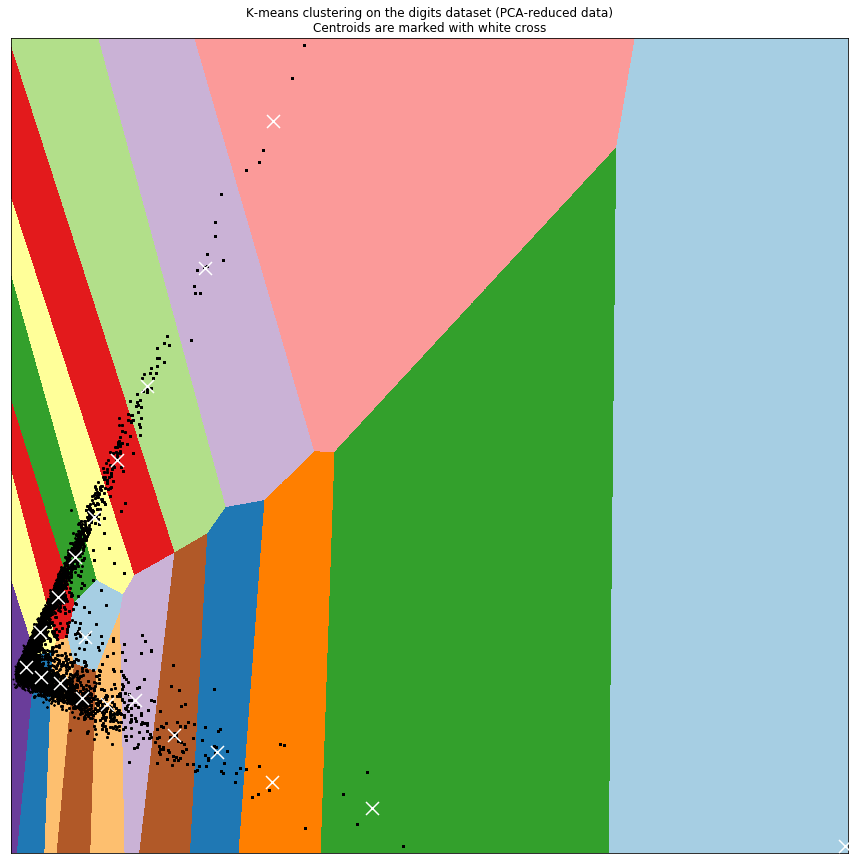

In [200]:
print(__doc__)
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans


data = result_user[:55000,:]

n_samples, n_features = data.shape
n_digits = 20

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = data
kmeans = KMeans(init='k-means++', n_clusters=n_digits)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(15,15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [201]:
def get_individuals(centroids, df, data, nb_individuals):
    res={}
    users=[]
    nb_centroids=len(centroids)
    for i in range(nb_centroids):
        res[str(i)]=[]
    a=0
    b=0
    while a<df.shape[0] and b==0:
        x=data[a,:].reshape(1, -1)
        user=df.iloc[a]["user_id"]
        if user not in users:
            for i in range(nb_centroids):
                if i==0:
                    close_centroid=0
                    min_distance=euclidean_distances(x, centroids[i].reshape(1, -1))[0][0]
                else:
                    dist=euclidean_distances(x, centroids[i].reshape(1, -1))[0][0]
                    if dist<min_distance:
                        close_centroid=i
            if len(res[str(close_centroid)])<nb_individuals:
                res[str(close_centroid)].append(user)
                users.append(user)
        a+=1
        z=list(res.values())
        w=1
        for j in z:
            w=w*len(j)
        if w==nb_individuals**nb_centroids:
            b=1
    return res

In [202]:
h=sorted(centroids,key=lambda x: x[0])
new_centroids=[]
for el in h:
    new_centroids.append(list(el))
new_centroids=np.array(new_centroids)

In [203]:
new_centroids

array([[-52.72533034,  -3.86202488],
       [-47.02398189,   1.19181765],
       [-46.58509233,  -5.43596934],
       [-40.17243893,   6.16347121],
       [-39.08017976,  -6.2510789 ],
       [-33.47373151,  11.89718367],
       [-30.50619867,  -8.40860813],
       [-29.35101733,   0.46431561],
       [-25.89376297,  17.72676033],
       [-20.49170513,  -9.2857291 ],
       [-16.69904709,  25.94936464],
       [ -9.59170754,  -8.71106548],
       [ -4.72123444,  36.54406   ],
       [  5.92496046, -13.68841053],
       [ 18.10511344,  53.5442959 ],
       [ 22.61704061, -16.15725059],
       [ 44.54992152, -20.56523657],
       [ 44.84251686,  74.78562747],
       [ 83.96342384, -24.31679815],
       [270.57790641, -29.70248931]])

In [204]:
individuals=get_individuals(centroids, train, result_user, 6)

In [205]:
individuals

{'0': [98355, 66489, 165051, 67353, 67454, 100330],
 '1': [],
 '2': [],
 '3': [],
 '4': [],
 '5': [],
 '6': [134714, 106090, 107302, 146155, 180600, 148860],
 '7': [],
 '8': [],
 '9': [131509, 131600, 164582, 164939, 182601, 99618],
 '10': [67673, 46376, 79688, 179313, 179658, 49815],
 '11': [35941, 172424, 174671, 110010, 111101, 146995],
 '12': [],
 '13': [],
 '14': [182764, 68587, 104514, 73517, 107196, 109796],
 '15': [],
 '16': [131084, 131085, 65576, 98497, 164192, 66018],
 '17': [98304, 65564, 65594, 163931, 131195, 65677],
 '18': [67317, 67694, 67853, 67966, 68170, 71069],
 '19': [65537, 65540, 65541, 65546, 65547, 158909]}

# split en deux avant -50 apres

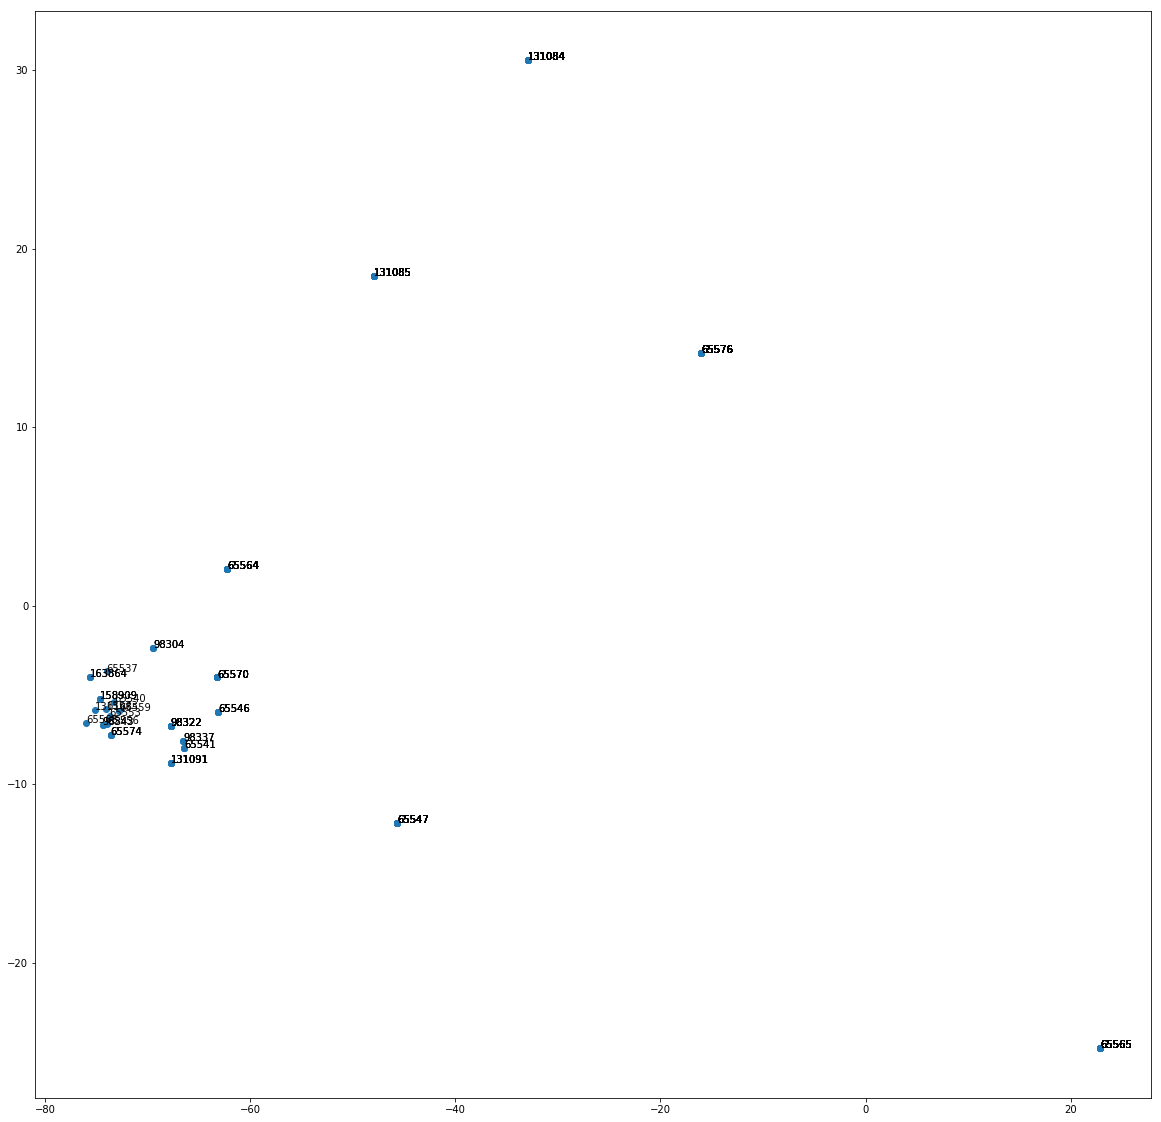

In [40]:
k=200
plt.figure(figsize=(20,20))
plt.scatter(result_user[:k, 0], result_user[:k, 1])
for i, word in enumerate(users[:k]):
    plt.annotate(word, xy=(result_user[i, 0], result_user[i, 1]))
plt.show()

In [227]:
train[train["user_id"]==98304][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
0,UK Sales Graduate Job 2019,P&G,"Consumer, FMCG & Retail",Sales & Commercial,Female,NaN,Durham University,History and Politics,Commercial Law
1,P&G Ireland Marketing Summer Internship 2019,P&G,"Consumer, FMCG & Retail","Consumer, FMCG & Retail",Female,NaN,Durham University,History and Politics,Commercial Law
2,P&G UK Sales Summer Internship,P&G,"Consumer, FMCG & Retail",Sales & Commercial,Female,NaN,Durham University,History and Politics,Commercial Law


In [228]:
train[train["user_id"]==65564][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
92,Pre-Masters Internship Programme (6 - 12 months),AlphaSights,Management & Business,Management & Business,Female,NaN,University of Bristol,Physics,Energy & Infrastructure
93,2018 UBS Talent Lab,UBS,Financial Services,Financial Services,Female,NaN,University of Bristol,Physics,Energy & Infrastructure
94,Overseas Programme,Schroders,Financial Services,Financial Services,Female,NaN,University of Bristol,Physics,Energy & Infrastructure
95,Technology Full-Time Analyst,Morgan Stanley,Financial Services,Technology: Consulting & Project Management,Female,NaN,University of Bristol,Physics,Energy & Infrastructure
96,Summer Internship,EY,Financial Services,Technology: Consulting & Project Management,Female,NaN,University of Bristol,Physics,Energy & Infrastructure
97,"Safety, Health & Environment Internship",Nestlé,"Consumer, FMCG & Retail",Technology: Consulting & Project Management,Female,NaN,University of Bristol,Physics,Energy & Infrastructure
98,Investment Consulting: Internship,Aon,Financial Services,Financial Services,Female,NaN,University of Bristol,Physics,Energy & Infrastructure


In [229]:
train[train["user_id"]==65594][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
273,Summer Vacation Scheme ? Internships,Deloitte,Consulting,"Accounting, Tax & Audit",Female,Mixed/Multiple Ethnic Background,London School of Economics and Political Scien...,Law,Entrepreneurship & Start Ups
274,Associate Programme 2019 intake,AlphaSights,Management & Business,Consulting,Female,Mixed/Multiple Ethnic Background,London School of Economics and Political Scien...,Law,Entrepreneurship & Start Ups
275,Off Cycle Internship,Goldman Sachs,Financial Services,Financial Services,Female,Mixed/Multiple Ethnic Background,London School of Economics and Political Scien...,Law,Entrepreneurship & Start Ups
276,Internships,Jane Street,Financial Services,Technology: Consulting & Project Management,Female,Mixed/Multiple Ethnic Background,London School of Economics and Political Scien...,Law,Entrepreneurship & Start Ups
277,Internship,Oliver Wyman,Consulting,Consulting,Female,Mixed/Multiple Ethnic Background,London School of Economics and Political Scien...,Law,Entrepreneurship & Start Ups
278,Content Strategy Intern (Summer 2018),Facebook,Technology: Consulting & Project Management,Technology: Consulting & Project Management,Female,Mixed/Multiple Ethnic Background,London School of Economics and Political Scien...,Law,Entrepreneurship & Start Ups


In [ ]:
train[train["user_id"]==172424][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

In [ ]:
train[train["user_id"]==172424][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

In [ ]:
train[train["user_id"]==172424][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

# Right low

In [69]:
train[train["user_id"]==164402][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
1437,Business Graduate Programme,London Stock Exchange Group,Financial Services,Financial Services,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN
1438,Graduate Data Analyst - Planning and Pricing,Cognizant,Technology: Consulting & Project Management,Technology: Consulting & Project Management,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN
1439,Global Research Global Graduate Programme,HSBC,Financial Services,Financial Services,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN
1440,Alpha Financial Markets Consulting Analyst,Alpha FMC,Financial Services,Financial Services,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN
1441,Cognizant Graduate Digital Careers,Cognizant,Technology: Consulting & Project Management,Technology: Consulting & Project Management,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN
1442,General Graduate Development Programme,Wellcome Trust,Charity & Social Enterprise,Charity & Social Enterprise,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN
1443,Retail Banking and Wealth Management - Graduat...,HSBC,Financial Services,Financial Services,Male,Mixed/Multiple Ethnic Background,Queen Mary University of London,Management,NaN


In [70]:
train[train["user_id"]==65985][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
1013,Graduate Analyst,Marsh Ltd,Financial Services,Financial Services,Male,NaN,Kings College London (KCL),Law,Commercial Law
1014,Legal Graduate Leadership Programme,Lloyds Banking Group,Financial Services,Financial Services,Male,NaN,Kings College London (KCL),Law,Commercial Law
1015,Finance Programme,Ocado,"Consumer, FMCG & Retail","Consumer, FMCG & Retail",Male,NaN,Kings College London (KCL),Law,Commercial Law
1016,Training Contract 2020 (Non-law),Dentons,Commercial Law,Commercial Law,Male,NaN,Kings College London (KCL),Law,Commercial Law
1017,Housing Graduate,Balfour Beatty,Technology: Consulting & Project Management,HR & Recruitment,Male,NaN,Kings College London (KCL),Law,Commercial Law
1018,Finance Graduate Program,Amazon,"Consumer, FMCG & Retail",Financial Services,Male,NaN,Kings College London (KCL),Law,Commercial Law
1019,Post Office Graduate Management Programme,Post Office,"Consumer, FMCG & Retail","Consumer, FMCG & Retail",Male,NaN,Kings College London (KCL),Law,Commercial Law


In [71]:
train[train["user_id"]==66004][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
1081,Graduate Programs,Credit Suisse,Investment Banking,Financial Services,Female,NaN,University of Cambridge,Linguistics,Commercial Law
1082,Training Contract 2020,Dentons,Commercial Law,Commercial Law,Female,NaN,University of Cambridge,Linguistics,Commercial Law
1083,New Analyst Programme,Goldman Sachs,Financial Services,Technology: Consulting & Project Management,Female,NaN,University of Cambridge,Linguistics,Commercial Law
1084,International Graduate Programme,Berenberg,Financial Services,Financial Services,Female,NaN,University of Cambridge,Linguistics,Commercial Law
1085,Graduate Workforce Manager,Cognizant,Technology: Consulting & Project Management,Technology: Consulting & Project Management,Female,NaN,University of Cambridge,Linguistics,Commercial Law
1086,Asset & Wealth Management - Wealth Management ...,J.P. Morgan,Financial Services,Investment & Asset Management,Female,NaN,University of Cambridge,Linguistics,Commercial Law
1087,Public Relations Graduate,Jaguar Land Rover,Technology: Consulting & Project Management,Marketing and PR,Female,NaN,University of Cambridge,Linguistics,Commercial Law


In [60]:
train[train["user_id"]==65565][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
125,Actuarial Graduate Opportunities 2018,PwC,Technology: Consulting & Project Management,Financial Services,F,Prefer not to say,City University London,Economics,"Accounting, Tax & Audit"
126,Retail Banking and Wealth Management - Graduat...,HSBC,Financial Services,Financial Services,F,Prefer not to say,City University London,Economics,"Accounting, Tax & Audit"
127,Finance Graduate Programme,npower,Engineering,Financial Services,F,Prefer not to say,City University London,Economics,"Accounting, Tax & Audit"
128,E-Commerce Graduate Program,Amazon,"Consumer, FMCG & Retail","Consumer, FMCG & Retail",F,Prefer not to say,City University London,Economics,"Accounting, Tax & Audit"
129,Assurance Summer Internship,PwC,Technology: Consulting & Project Management,Financial Services,F,Prefer not to say,City University London,Economics,"Accounting, Tax & Audit"
130,Finance Graduate Program,Amazon,"Consumer, FMCG & Retail",Financial Services,F,Prefer not to say,City University London,Economics,"Accounting, Tax & Audit"
131,2018 Intake- Graduate- UKI Advisory- Risk (ITRA),EY,Financial Services,Financial Services,F,Prefer not to say,City University London,Economics,"Accounting, Tax & Audit"


In [73]:
train[train["user_id"]==98773][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
1115,Global Graduate Leadership Programme,Aviva,Insurance & Risk Management,Financial Services,Female,NaN,Durham University,Business (Management),Commercial Law
1116,New Grad (Undergrad) - Project Management,Visa,Financial Services,Technology: Consulting & Project Management,Female,NaN,Durham University,Business (Management),Commercial Law
1117,Global Technology Analyst Program,Bank of America Merrill Lynch,Financial Services,Financial Services,Female,NaN,Durham University,Business (Management),Commercial Law
1118,Entry-Level Consultant,Oliver Wyman,Consulting,Consulting,Female,NaN,Durham University,Business (Management),Commercial Law
1119,"SMB Account Manager, Graduate (UK&I)",Facebook,Technology: Consulting & Project Management,Technology: Consulting & Project Management,Female,NaN,Durham University,Business (Management),Commercial Law
1120,Finance Graduate Program,Amazon,"Consumer, FMCG & Retail",Financial Services,Female,NaN,Durham University,Business (Management),Commercial Law
1121,Securities Trading,UBS,Financial Services,Financial Services,Female,NaN,Durham University,Business (Management),Commercial Law


# left low

In [74]:
train[train["user_id"]==65616][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
307,Chemical Engineer Graduate,ExxonMobil,Engineering,Engineering,Male,NaN,University of Warwick,Engineering - Mechanical,NaN
308,Graduate Engineer,McLaren Automotive,Engineering,Engineering,Male,NaN,University of Warwick,Engineering - Mechanical,NaN


In [77]:
train[train["user_id"]==98481][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
497,Sales & Marketing Graduate Scheme,Mondelez International,"Consumer, FMCG & Retail","Consumer, FMCG & Retail",Male,NaN,Durham University,Ppe,Commercial Law
498,Commercial programme,BAE Systems,Technology: Consulting & Project Management,Technology: Consulting & Project Management,Male,NaN,Durham University,Ppe,Commercial Law
499,Global Graduate Leadership Programme,Aviva,Insurance & Risk Management,Financial Services,Male,NaN,Durham University,Ppe,Commercial Law
500,Associate Programme 2019 intake,AlphaSights,Management & Business,Consulting,Male,NaN,Durham University,Ppe,Commercial Law
501,Business Roles,BP,Engineering,Technology: Consulting & Project Management,Male,NaN,Durham University,Ppe,Commercial Law
502,Commercial - Sales & Marketing Graduate Programme,Danone,"Consumer, FMCG & Retail",Marketing and PR,Male,NaN,Durham University,Ppe,Commercial Law
503,Downstream Commercial,Shell,Engineering,Engineering,Male,NaN,Durham University,Ppe,Commercial Law


In [231]:
train[train["user_id"]==100622][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
7104,Energy Specialist,Bulb,Entrepreneurship & Start Ups,Energy & Infrastructure,Female,White/White British,Durham University,Geography,Energy & Infrastructure


In [62]:
train[train["user_id"]==65556][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
82,Graduate Legal Project Manager,Linklaters,Commercial Law,Commercial Law,Female,NaN,Durham University,Law,Commercial Law


In [63]:
train[train["user_id"]==65546][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
8,Rotational Associates Program,DE Shaw & Co.,Financial Services,Financial Services,Male,NaN,City University London,Finance,Investment Banking
9,Graduate Analyst - London,Greensill,Financial Services,Financial Services,Male,NaN,City University London,Finance,Investment Banking
10,Graduate Opportunities,Guernsey Financial Services Commission,Financial Services,Financial Services,Male,NaN,City University London,Finance,Investment Banking
11,Investment Banking Summer Associate,Piper Jaffray,Financial Services,Financial Services,Male,NaN,City University London,Finance,Investment Banking
12,Equity Analyst Graduate Programme,Close Brothers Group plc,Financial Services,Financial Services,Male,NaN,City University London,Finance,Investment Banking


In [64]:
train[train["user_id"]==65541][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
5,Strategy Graduate Programme,Accenture,Technology: Consulting & Project Management,Technology: Consulting & Project Management,Female,Mixed/Multiple Ethnic Background,University of York,Mathematics,Investment Banking
6,Consulting Graduate Programme,EY,Financial Services,Financial Services,Female,Mixed/Multiple Ethnic Background,University of York,Mathematics,Investment Banking
7,Herbert Smith Freehills Graduate Competition,Herbert Smith Freehills,Commercial Law,Commercial Law,Female,Mixed/Multiple Ethnic Background,University of York,Mathematics,Investment Banking


In [ ]:
k=20
plt.figure(figsize=(20,20))
plt.scatter(result[:k, 0], result[:k, 1])
for i, word in enumerate(infos[:k]):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [29]:
list(cosine_similarity(X_train[0,:].reshape(1, -1) , X_train))[0]

array([1.        , 0.93048404, 0.98082065, ..., 0.37889678, 0.51612744,
       0.08515185])

In [30]:
def get_similar_doc(X_train, doc_id, n):
    res=[]
    beta=[]
    cos=list(cosine_similarity(X_train[doc_id,:].reshape(1, -1) , X_train))[0]
    most_similar_doc_id=np.argsort(cos)[::-1]
    a=0
    while cos[most_similar_doc_id[a]]>=0.9999999:
        a+=1
    most_similar_doc_id=most_similar_doc_id[a:]
    res.append(most_similar_doc_id[0])
    beta.append(cos[most_similar_doc_id[0]])
    for i in range(1,len(most_similar_doc_id)):
        if cos[most_similar_doc_id[i]] not in beta:
            res.append(most_similar_doc_id[i])
            beta.append(cos[most_similar_doc_id[i]])
    print("most similar doc : ", res[:n])
    print("not similar doc : ", res[-n:][::-1])

In [87]:
get_similar_doc(X_train, 5000, 5)

most similar doc :  [111058, 88574, 9701, 41300, 50374]
not similar doc :  [62222, 89471, 119665, 120738, 89090]


In [32]:
def clean_similarity(x):
    res=[] 
    for content in x:
        content=content.replace("&bull;","\r\n ").replace("\r\r\n\t"," ").replace("\r\r\n"," ")
        content=content.replace("\r\r\n\r\r\n"," ").replace("..."," ").replace("&#39;s","").replace(":","")
        content=content.replace("&eacute;","e").replace("&lsquo;","").replace("&#39;","")
        content=content.replace("&nbsp;"," ").replace("&#39;","").replace("amp;","").replace("&middot;","")
        content=content.replace("."," ").replace(",","").replace("?"," ").replace("!","").replace("  "," ")
        content=content.replace("&rsquo;","").replace("\t"," ").replace("\r\n\r\n","").replace(" \r\n ","")
        content=content.replace("&ndash;"," ").replace("\r\n\r\n"," ").replace(" \r\n "," ").replace("\r\n"," ")
        content=content.replace("\r"," ").replace("  ","").replace("   ","").replace("  ","").replace("   ","")
        content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
        content=re.sub('<.*?>',"",content , flags=re.DOTALL)
        res.append(content)
    return res

In [33]:
data_similarity=clean_similarity(train_job_info)

In [88]:
data_similarity[5000]

'Trainee Recruitment Consultant Graduate Financial Services Trainee Recruitment Consultant Are you a recent graduate looking to gain real experience in a professional environment At Robert Half were currently on the lookout for ambitious and driven graduates to join our Birmingham office  For more than 65 years Robert Half has been a multi-award winning global leader within the recruitment industry With its roots beginning in the U S the company has expanded its operations to more than 20 countries worldwide with 18+ offices in the UK alone Not only have we been featured on the FTSE green listing for our ethics first values but have also been recognised as on the Sunday Times Best Companies to Work For consistent basis Consecutively featured in Fortune Magazine list of the World Most Admired Companies our name is widely-recognised and we have established relationships with UK businesses across a wide range of industries  What Robert Half will offer you  Impressive training program that

In [89]:
data_similarity[111058]

'Graduate Resourcer Consultant Consulting Overview Robert Half is currently looking to recruit a Graduate Resourcer Consultant to join their growing Permanent Services Division in Central Nottingham This is a busy exciting role which is demanding and rewarding in equal measure  Robert Half is currently looking to recruit a Graduate Resourcer Consultant to join their growing Permanent Services Division in Central Nottingham This is a busy exciting role which is demanding and rewarding in equal measure The opportunity is massive for both earning potential and career development although consistent hard work will be required to achieve these  The Role This is a broad ranging role that will see you gain an ideal entry point into a recruitment career in one of the largest professional recruitment businesses worldwide Your key responsibilities will be  Attracting and engaging candidates to Robert Half through writing job adverts social media monitoring databases and telephone work Implement 

In [91]:
data_similarity[119665]

'Data Engineer Analytics Intern Summer 2018 Technology Consulting & Project Management Overview Facebook mission is to give people the power to build community and bring the world closer together Through our family of apps and services were building a different kind of company that connects billions of people around the world gives them ways to share what matters most to them and helps bring people closer together Whether were creating new products or helping a small business expand its reach people at Facebook are builders at heart Our global teams are constantly iterating solving problems and working together to empower people around the world to build community and connect in meaningful ways Together we can help people build stronger communities &mdash; were just getting started  Would you like to work with big data Do you want to use data to influence product decisions for products being used by over half a billion people every day If yes we want to talk to you Our data warehouse t

In [43]:
X_train.shape

(125136, 200)

In [44]:
job_characteristics.shape

(125136, 6)